In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
from math import pi
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField
from my_handy_functions import *

In [2]:
a = 1  # wave speed
b = 0.1  # diffusivity
solution_name = "u"
equation = PDE({solution_name: f"- {a} * d_dx(u) + {b} * laplace(u)"},
                # bc={"value": "cos(x)"}
                )

x_min = -pi
x_max = pi
x_num_elements = 256

grid = CartesianGrid([[x_min, x_max]], [x_num_elements], periodic=True)
state = ScalarField.from_expression(grid, "sin(x)+cos(2*x)")

t_max = pi
t_num_elements = 256

storage = MemoryStorage()
result = equation.solve(state, t_range=t_max, tracker=storage.tracker(t_max/t_num_elements))

x = np.ravel(storage.grid.axes_coords)
t = np.ravel(storage.times)

In [3]:
u = np.real(storage.data)

In [4]:
def plot_solution(x, t, u, main_str):
    plt.figure()
    plt.pcolormesh(x, t, u)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('t', fontsize=16)
    plt.title(main_str, fontsize=16)
    plt.colorbar()

def plot_derivatives(x, t, u, solution_name):

    for axis, (label, v, n) in enumerate(zip(["t", "x"], [t, x], [1, 2])):
        dv = v[1] - v[0]
        for d in range(1, 1+n):
            u_i = ps.FiniteDifference(d=d, axis=axis)._differentiate(u, t=dv)
            suffix = label*d
            plot_solution(x, t, u_i, f"${solution_name}_{{{suffix}}}$")

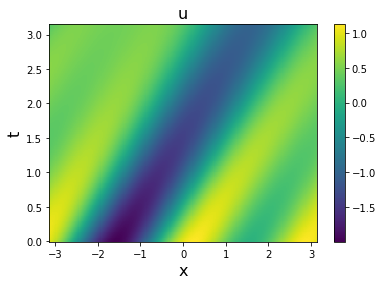

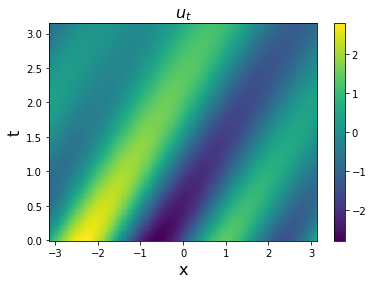

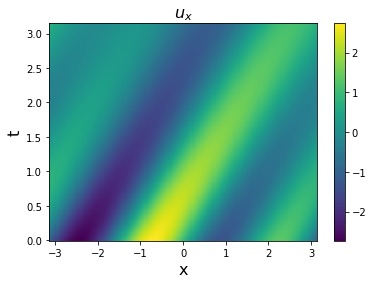

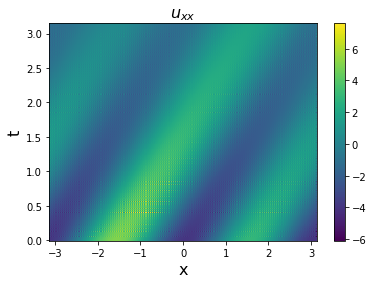

In [5]:
plot_solution(x, t, u, solution_name)
plot_derivatives(x, t, u, solution_name)

In [6]:
def get_model(threshold):
    library_functions = [lambda x: x, lambda x: x * x]
    library_function_names = [lambda x: x, lambda x: x + x]

    pde_lib = ps.PDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=2, spatial_grid=x, 
                            include_bias=True, is_uniform=True
                            )
    optimizer=ps.STLSQ(threshold=threshold, alpha=1e-5, normalize_columns=True)
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=solution_name)
    return(model)

In [11]:
clean_model = get_model(20)
u_r = np.transpose(u).reshape(len(x), len(t), 1)
clean_model.fit(u_r, t=t[1]-t[0])
print_result(clean_model, solution_name)

Feature library:
['1', 'u', 'uu', 'u_x', 'u_xx', 'uu_x', 'uuu_x', 'uu_xx', 'uuu_xx']
STLSQ model:
(u)' = -1.000 u_1 + 0.096 u_11


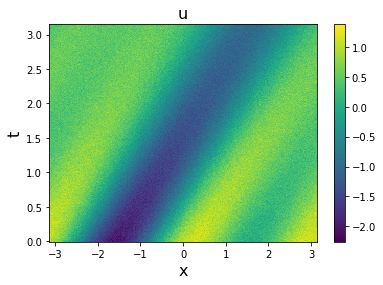

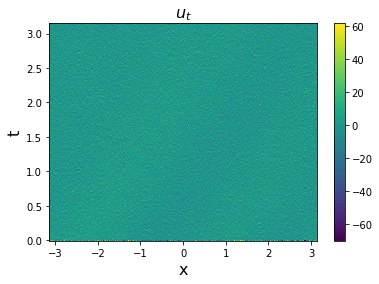

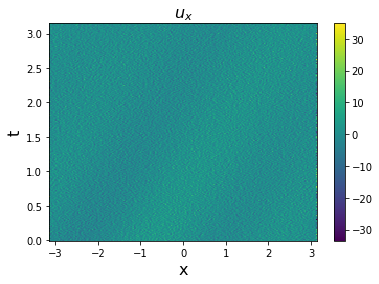

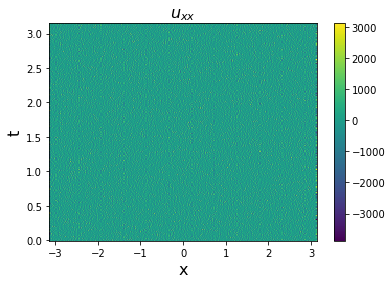

In [8]:
sd = 0.01
u_noisy = noisify(u, 0.1)
plot_solution(x, t, u_noisy, solution_name)
plot_derivatives(x, t, u_noisy, solution_name)

In [31]:
noisy_model = get_model(20)
u_noisy_r = np.transpose(u_noisy).reshape(len(x), len(t), 1)
noisy_model.fit(u_noisy_r, t=t[1]-t[0])
print_result(noisy_model, solution_name)

Feature library:
['1', 'u', 'uu', 'u_x', 'u_xx', 'uu_x', 'uuu_x', 'uu_xx', 'uuu_xx']
STLSQ model:
(u)' = -0.212 u + -0.188 u_1 + 0.117 uu_1 + 0.118 uu_11
